In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Conv2DTranspose, Conv2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

### Seperating the fire data

In [2]:
def seperate_disaster(source_folder, pre_folder, post_folder):
    source_folder = source_folder
    pre_folder = os.path.join(os.curdir, pre_folder)
    post_folder = os.path.join(os.curdir, post_folder)

    # Creating the destination folders
    os.makedirs(pre_folder, exist_ok=True)
    os.makedirs(post_folder, exist_ok=True)

    # Iterate through files in the source
    for filename in os.listdir(source_folder):
        if "fire" in filename.lower(): # Check for "hurricane" images
            if "pre_disaster" in filename:        
                shutil.move(os.path.join(source_folder,filename), os.path.join(pre_folder,filename))
            elif "post_disaster" in filename:    
                shutil.move(os.path.join(source_folder,filename), os.path.join(post_folder,filename))
    return
    

In [3]:
seperate_disaster(source_folder='train/images', pre_folder='fire/train/pre_disaster', post_folder='fire/train/post_disaster')
seperate_disaster(source_folder='hold/images', pre_folder='fire/hold/pre_disaster', post_folder='fire/hold/post_disaster')
seperate_disaster(source_folder='test/images', pre_folder='fire/test/pre_disaster', post_folder='fire/test/post_disaster')

### Creating the cGAN architecture

In [4]:
# Generator
def build_generator():
    inputs = Input(shape=[256,256,3])

    down_stack = [
        Conv2D(64, (4,4), strides=2, padding='same', activation='relu'),
        Conv2D(128, (4,4), strides=2, padding='same', activation='relu'),
        Conv2D(256, (4,4), strides=2, padding='same', activation='relu'),
        Conv2D(512, (4,4), strides=2, padding='same', activation='relu'),
    ]

    up_stack = [
        Conv2DTranspose(256, (4,4), strides=2, padding='same', activation='relu'),
        Conv2DTranspose(128, (4,4), strides=2, padding='same', activation='relu'),
        Conv2DTranspose(64, (4,4), strides=2, padding='same', activation='relu'),
    ]
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = Concatenate()([x, skip])
    
    last = Conv2DTranspose(3, (4,4), strides=2, padding='same', activation='tanh')
    x = last(x)

    return Model(inputs, x)

In [5]:
# Discriminator
def build_discriminator():
    inp = Input(shape=[256,256,3])
    target = Input(shape=[256,256,3])
    x = Concatenate()([inp, target])

    x = Conv2D(64, (4,4), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(128, (4,4), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(256, (4,4), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(512, (4,4), strides=1, padding='same', activation='relu')(x)
    x = Conv2D(1, (4,4), padding='same', activation='sigmoid')(x)

    return Model([inp, target], x)

In [6]:
# Loss functions
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss= BinaryCrossentropy()(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = MeanAbsoluteError()(target, gen_output)
    return gan_loss + (100 * l1_loss)    

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = BinaryCrossentropy()(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = BinaryCrossentropy()(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + fake_loss

In [7]:
# Initialize models
generator = build_generator()
discriminator = build_discriminator()
gen_optimizer = Adam(2e-4, beta_1=0.5)
disc_optimizer = Adam(2e-4, beta_1=0.5)

In [10]:
# Training loop
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        g_loss = generator_loss(disc_generated_output, gen_output, target)
        d_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    gen_gradients = gen_tape.gradient(g_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    
    return g_loss, d_loss

In [8]:
# Modify the function to handle both pre- and post-disaster images
def load_image_train(pre_image_path, post_image_path):
    pre_image = tf.io.read_file(pre_image_path)
    pre_image = tf.image.decode_jpeg(pre_image)
    pre_image = tf.image.resize(pre_image, [256, 256])
    pre_image = (tf.cast(pre_image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]

    post_image = tf.io.read_file(post_image_path)
    post_image = tf.image.decode_jpeg(post_image)
    post_image = tf.image.resize(post_image, [256, 256])
    post_image = (tf.cast(post_image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]

    return pre_image, post_image

In [9]:
# Load dataset
def load_dataset(pre_folder, post_folder):
    pre_images = sorted(os.listdir(pre_folder))
    post_images = sorted(os.listdir(post_folder))
    
    pre_image_paths = [os.path.join(pre_folder, f) for f in pre_images]
    post_image_paths = [os.path.join(post_folder, f) for f in post_images]
    
    dataset = tf.data.Dataset.from_tensor_slices((pre_image_paths, post_image_paths))
    dataset = dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1).shuffle(400).prefetch(tf.data.AUTOTUNE)
    return dataset

In [158]:
# Training function
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for input_image, target in dataset:
            g_loss, d_loss = train_step(input_image, target)
        print(f"Generator Loss: {g_loss.numpy()}, Discriminator Loss: {d_loss.numpy()}")
    print("Training Complete!")

In [11]:
pre_folder = r"fire\train\pre_disaster"
post_folder = r"fire\train\post_disaster"

data = load_dataset(post_folder, pre_folder)

In [ ]:
train(data, 100)

Epoch 1/100
Generator Loss: 18.703350067138672, Discriminator Loss: 0.5786262154579163
Epoch 2/100
Generator Loss: 13.028482437133789, Discriminator Loss: 0.38678064942359924
Epoch 3/100
Generator Loss: 11.561847686767578, Discriminator Loss: 0.9404793977737427
Epoch 4/100
Generator Loss: 18.498027801513672, Discriminator Loss: 0.36589062213897705
Epoch 5/100
Generator Loss: 21.607574462890625, Discriminator Loss: 0.5593547821044922
Epoch 6/100
Generator Loss: 18.264856338500977, Discriminator Loss: 0.3692629635334015
Epoch 7/100
Generator Loss: 14.158745765686035, Discriminator Loss: 0.4096437096595764
Epoch 8/100
Generator Loss: 15.312478065490723, Discriminator Loss: 0.8325045704841614
Epoch 9/100
Generator Loss: 13.299114227294922, Discriminator Loss: 1.5896676778793335
Epoch 10/100
Generator Loss: 13.122997283935547, Discriminator Loss: 0.5310227870941162
Epoch 11/100
Generator Loss: 12.005250930786133, Discriminator Loss: 1.993915319442749
Epoch 12/100
Generator Loss: 19.61268043

In [1]:
# Save the generator model
generator.save('generator')

NameError: name 'generator' is not defined

In [12]:
# Load generator model
generator = load_model('generator')

In [13]:
def predict_image(generator, input_image_path):
    input_image = tf.io.read_file(input_image_path)
    input_image = tf.image.decode_jpeg(input_image)
    input_image = tf.image.resize(input_image, [256, 256])
    input_image = (tf.cast(input_image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
    predicted_image = generator(input_image, training=False)[0]
    predicted_image = (predicted_image + 1) / 2  # Denormalize to [0, 1]
    
    plt.imshow(predicted_image.numpy())
    plt.axis('off')
    plt.show()

In [14]:
def show_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)  # Decode the image
    image = (tf.cast(image, tf.float32) / 255.0)  # Normalize to [0,1]

    plt.imshow(image)
    plt.axis('off')

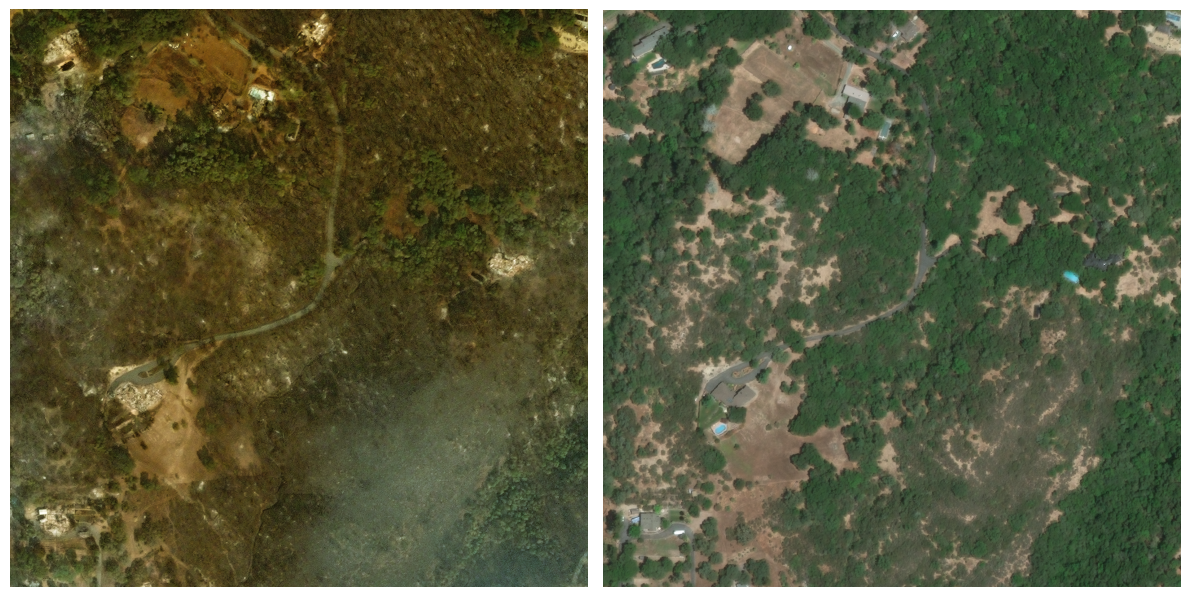

In [15]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
show_image(r"G:\Study\Pre-Disaster Damage Reconstruction\fire\train\post_disaster\santa-rosa-wildfire_00000055_post_disaster.png")

plt.subplot(1,2,2)
show_image(r"G:\Study\Pre-Disaster Damage Reconstruction\fire\train\pre_disaster\santa-rosa-wildfire_00000055_pre_disaster.png")

plt.tight_layout()
plt.show()

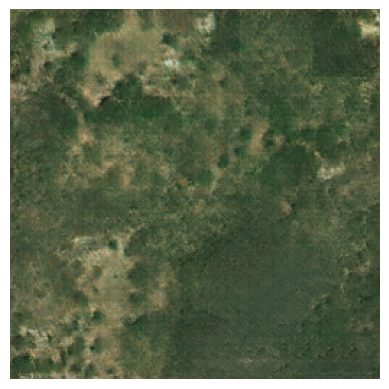

In [16]:
predict_image(generator,r"G:\Study\Pre-Disaster Damage Reconstruction\fire\train\post_disaster\santa-rosa-wildfire_00000055_post_disaster.png" )